Simulate synaptic input to a model neuron with a soma and dendrite. The soma contains HH ion channels whereas the dendrite only contains a leak (passive) conductance.

In [1]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')

# Build morphology
soma = h.Section(name='soma')
dend = h.Section(name='dend')

soma.L = soma.diam = 20.0    # µm, compact soma
dend.L = 200.0               # µm
dend.diam = 1.0              # µm

# Connect dend(0) to soma(1)
dend.connect(soma(1))

# Biophysics
for sec in [soma, dend]:
    sec.Ra = 100    # ohm*cm
    sec.cm = 1.0    # µF/cm^2

# Active soma (to allow AP generation if input is strong)
soma.insert('hh')
# Passive dendrite
dend.insert('pas')
dend.g_pas = 1.0e-4      # S/cm^2 (adjust for larger/smaller EPSPs)
dend.e_pas = -65.0       # mV

# Spatial discretization for accuracy
dend.nseg = 11

Insert a synapse and connect it to a stimulator.
  - ExpSyn:
    - Produces a single-exponential conductance transient with time constant syn.tau.
    - syn.e is the reversal potential (mV) used with driving force (V - e).
  - NetCon weight:
    - For conductance-based point processes (ExpSyn, Exp2Syn), NetCon.weight units are µS.
    - For current-injecting point processes (IClamp), weight would be nA.
  - NetStim:
    - NetStim provides externally defined spike times.
    - Delay on NetCon is added on top of each event time.
  - Threshold:
    - NetCon.threshold matters when the source is a membrane variable (spike detector).
      For NetStim as source, threshold is ignored. 

In [2]:
# Synapse on dendrite (midpoint)
syn = h.ExpSyn(dend(0.5))
syn.tau = 2.0            # ms, decay time constant
syn.e = 0.0              # mV, excitatory reversal (AMPA-like)

# VecStim -> NetCon to drive synapse with specified spike times
ns = h.NetStim()
ns.start = 10.0       # ms: time of first event
ns.number = 5         # total events
ns.interval = 10.0    # ms between events -> events at 10,20,30,40,50 ms when noise=0
ns.noise = 0.0        # 0 = strictly regular; increase towards 1 for stochastic timings

nc = h.NetCon(ns, syn)
nc.delay = 1.0           # ms transmission delay
nc.weight[0] = 0.001     # µS (conductance units for ExpSyn). Change to scale EPSP.

In [3]:
# Recordings
tvec = h.Vector()
v_soma = h.Vector()
v_dend = h.Vector()

tvec.record(h._ref_t)
v_soma.record(soma(0.5)._ref_v)
v_dend.record(dend(0.5)._ref_v)

# Run
h.finitialize(-65.0)
h.continuerun(120.0)


0.0

In [ ]:
Plot simulation outputs.

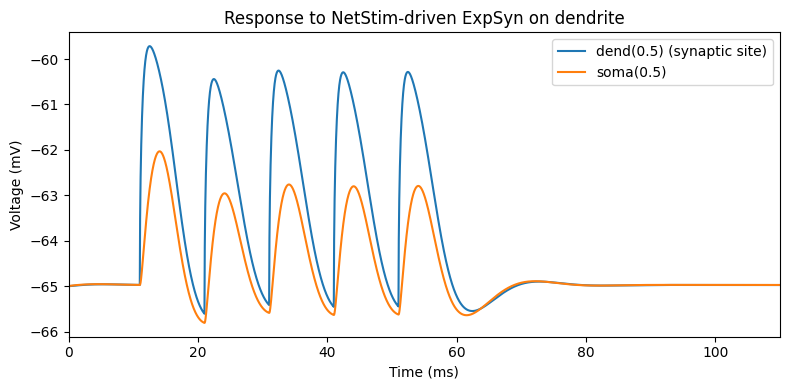

In [4]:
# Convert to numpy for plotting
t = np.array(tvec)
v_s = np.array(v_soma)
v_d = np.array(v_dend)

# Plot
plt.figure(figsize=(8,4))
plt.plot(t, v_d, label='dend(0.5) (synaptic site)')
plt.plot(t, v_s, label='soma(0.5)')
plt.xlim(0,110) # To set the x axis range
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.title('Response to NetStim-driven ExpSyn on dendrite')
plt.tight_layout()
plt.show()

- Each spike time in spike_times produces a transient increase in synaptic conductance,
    producing an EPSC (conductance * driving force) and an EPSP at the dendritic site.
- Note how the EPSP attenuates as it spreads to the soma — measured differences between dend and soma.
- Increasing nc.weight produces larger EPSPs; if the soma has active HH channels,
    sufficiently strong or closely timed EPSPs can trigger somatic action potentials.

Things to try:
- Change syn.tau (e.g., 0.5, 5, 10 ms) to see effects of kinetics on EPSP shape.
- Vary nc.weight to explore linear vs. supralinear summation; find weight that elicits spikes.
- Move the synapse location (dend(x)) and observe attenuation to soma.

The code below makes a more complicated plot that also shows the stimulus times.

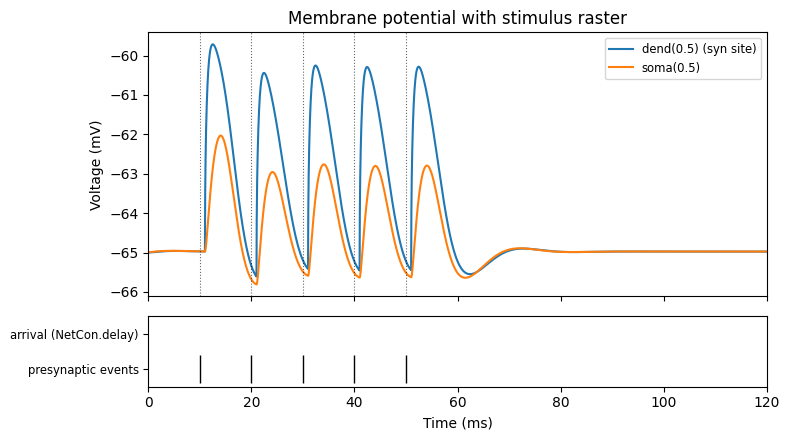

In [5]:
import matplotlib.pyplot as plt

# --- derive presynaptic event times ---
presyn_times = np.array([])
if 'times' in globals():
	# you provided an explicit Python list of times
	presyn_times = np.array(times, dtype=float)
elif 'netstims' in globals():
	# list of one-shot NetStim objects (each netstim.start is the event time)
	presyn_times = np.array([float(ns_i.start) for ns_i in netstims])
elif 'ns' in globals():
	# single NetStim; only reconstruct deterministic times when noise == 0
	if float(getattr(ns, 'noise', 0.0)) == 0.0:
		n = int(ns.number)
		presyn_times = np.array([float(ns.start) + i * float(ns.interval) for i in range(n)])
	else:
		# stochastic NetStim: recommend recording times explicitly during simulation.
		# Here we warn and approximate by drawing one realization (not reproducible)
		import warnings
		warnings.warn("ns.noise > 0: event times are stochastic. Consider recording events during simulation.")
		# fallback: approximate mean times (not exact)
		n = int(ns.number)
		presyn_times = np.array([float(ns.start) + i * float(ns.interval) for i in range(n)])
else:
	# no recognized stimulus representation found
	presyn_times = np.array([])

# arrival times = presynaptic times + NetCon delay (assume nc_ampa exists)
syn_delay = float(nc_ampa.delay) if 'nc_ampa' in globals() else 0.0
arrival_times = presyn_times + syn_delay

# --- make figure with subpanels ---
fig, (ax_v, ax_evt) = plt.subplots(2, 1, sharex=True,
									gridspec_kw={'height_ratios': [3, 0.8]},
									figsize=(8, 4.5))

# Top: membrane potentials
ax_v.plot(t, v_d, label='dend(0.5) (syn site)', color='C0')
ax_v.plot(t, v_s, label='soma(0.5)', color='C1')
ax_v.set_ylabel('Voltage (mV)')
ax_v.legend(loc='upper right', fontsize='small')
ax_v.set_title('Membrane potential with stimulus raster')

# Bottom: stimulus raster / eventplot (two rows: presynaptic and arrival)
# Use eventplot; provide two sequences -> two rows
sequences = []
labels = []
colors = []
if presyn_times.size > 0:
	sequences.append(presyn_times)
	labels.append('presynaptic events')
	colors.append('0.4')   # grey
else:
	sequences.append(np.array([]))
	labels.append('presynaptic events')
	colors.append('0.4')

sequences.append(arrival_times)
labels.append('arrival (NetCon.delay)')
colors.append('k')       # black

# eventplot draws horizontal lines at different y offsets; linelengths controls marker length
ax_evt.eventplot(sequences, colors=colors, linelengths=0.8, linewidths=1.0)

# tidy bottom axis
ax_evt.set_ylim(0.5, 2.5)   # show two rows clearly
ax_evt.set_yticks([1.0, 2.0])
ax_evt.set_yticklabels(labels, fontsize='small')
ax_evt.set_xlabel('Time (ms)')
ax_evt.set_xlim(t.min(), t.max())

# optional: add small vertical markers to the top panel at arrival times (dotted lines)
for ta in arrival_times:
	ax_v.axvline(ta, color='k', linestyle=':', linewidth=0.8, alpha=0.6)

plt.tight_layout()
plt.show()


In [6]:
dir(h)

['APCount',
 'AlphaSynapse',
 'AtolTool',
 'AtolToolItem',
 'Avogadro_constant',
 'BBSaveState',
 'CVode',
 'DEG',
 'Deck',
 'E',
 'ExecCommand',
 'Exp2Syn',
 'ExpSyn',
 'FARADAY',
 'FInitializeHandler',
 'Family',
 'File',
 'GAMMA',
 'GUIMath',
 'Glyph',
 'Graph',
 'HBox',
 'IClamp',
 'Impedance',
 'Inserter',
 'IntFire1',
 'IntFire2',
 'IntFire4',
 'KSChan',
 'KSGate',
 'KSState',
 'KSTrans',
 'L',
 'LinearMechanism',
 'List',
 'Matrix',
 'MechanismStandard',
 'MechanismType',
 'MenuExplore',
 'NEURONMainMenu',
 'NetCon',
 'NetStim',
 'NumericalMethodPanel',
 'OClamp',
 'PHI',
 'PI',
 'PPShape',
 'PWManager',
 'ParallelContext',
 'PatternStim',
 'Plot',
 'PlotShape',
 'PointBrowser',
 'PointProcessLocator',
 'PointProcessManager',
 'PointProcessMark',
 'Pointer',
 'PtrVector',
 'PythonObject',
 'R',
 'Ra',
 'Random',
 'RangeVarPlot',
 'SEClamp',
 'SaveState',
 'Section',
 'SectionBrowser',
 'SectionList',
 'SectionRef',
 'Shape',
 'ShapeBrowser',
 'ShapeLocation',
 'SingleChan',
 'St